In [1]:
########################################################################
#####                   DREAM - MPPC Recording                     #####
########################################################################

In [2]:
##### Import Libraries
import numpy as np
import time
import os
import pickle
import matplotlib.pyplot as plt
import datetime
from mcculw import ul
from ctypes import cast, POINTER, c_double, c_ushort, c_ulong 
from mcculw.enums import (ScanOptions, FunctionType, Status, ChannelType, 
    DigitalPortType, ULRange, TriggerSource, TriggerSensitivity, TriggerEvent, 
    DigitalIODirection, TimerIdleState, PulseOutOptions, TrigType)
from mcculw.device_info import DaqDeviceInfo

try:
    from console_examples_util import config_first_detected_device
except ImportError:
    from console_examples_util import config_first_detected_device

## SETUP DAQ

In [3]:
########################################################
##### SETUP EQUIPMENT

##### Connect to the DAQ Card
board_num = 0
daq_dev_info = DaqDeviceInfo(board_num = 0)

##### Setup DAQ for analog input
ai_info = daq_dev_info.get_ai_info()
ai_range = ai_info.supported_ranges[2]

## Set the scan options
scan_options_AI = ScanOptions.BACKGROUND

## AQUISITION SETTINGS

In [4]:
DAQ_Rate = 200000 # [Hz]
Exp_Duration = 5 #[s]
total_count = int(DAQ_Rate * Exp_Duration)
EXPNAME = "RANDOM_92_2"

In [5]:
## Allocate a buffer for the input

if ai_info.resolution <= 16:
    # Use the win_buf_alloc method for devices with a resolution <= 16
    memhandle_AI = ul.win_buf_alloc(total_count)
    # Convert the memhandle to a ctypes array.
    ctypes_array_AI = cast(memhandle_AI, POINTER(c_ushort))
else:
    # Use the win_buf_alloc_32 method for devices with a resolution > 16
    memhandle_AI = ul.win_buf_alloc_32(total_count)
    # Convert the memhandle to a ctypes array.
    ctypes_array_AI = cast(memhandle_AI, POINTER(c_ulong))

if not memhandle_AI:
    raise Exception('Error: Failed to allocate memory')


## RUN EXPERIMENT

In [6]:
## Start the timer, which will start and pace AO and AI
ul.a_in_scan(board_num, 3, 3, (int (DAQ_Rate*Exp_Duration)), DAQ_Rate, ai_range, memhandle_AI, scan_options_AI)

## Wait until AI Finishes
status, curr_count, curr_index = ul.get_status(board_num, FunctionType.AIFUNCTION)
while status != Status.IDLE:
    time.sleep(0.5)
    status, curr_count, curr_index = ul.get_status(
            board_num, FunctionType.AIFUNCTION)

## READ AND SAVE ANALOG INPUT

In [7]:
points = []
for i in range((int (DAQ_Rate*Exp_Duration))):
    eng_value = ul.to_eng_units(board_num, ai_range, ctypes_array_AI[i])
    points.append(eng_value)
DAQ_signal = np.array(points)

In [8]:
len(DAQ_signal)

1000000

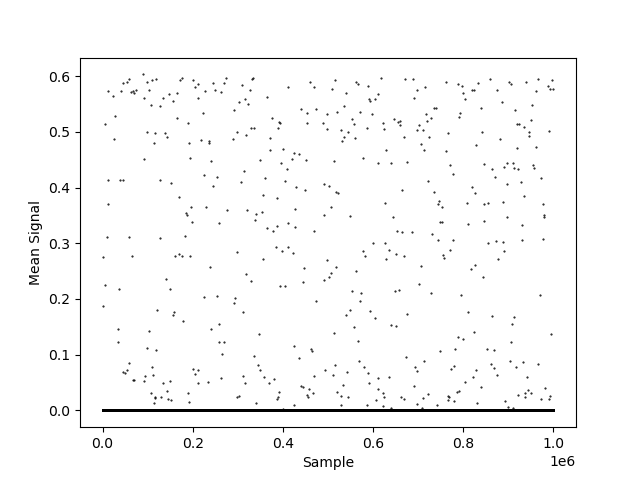

In [9]:
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import tools

## Display the data recorded
%matplotlib widget
plt.figure()
plt.xlabel('Sample')
plt.ylabel('Mean Signal')
#plt.plot(tools.moving_average(DAQ_signal,int(DAQ_Rate*0.1)), "-", markersize=0.5)
plt.plot(DAQ_signal, "ko", markersize=0.5)
plt.show()



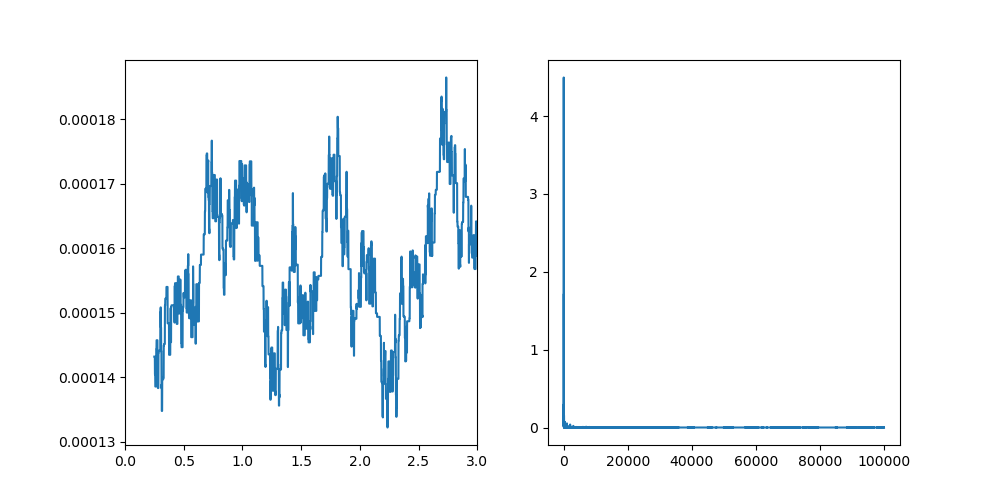

In [10]:
t = np.arange(0,5,1/DAQ_Rate)
window = 100000
fig, ax = plt.subplots(1,2, figsize = (10,5))
F, A, P = tools.FFT(tools.moving_average(t, window), tools.moving_average(DAQ_signal,window), False)
ax[0].plot(tools.moving_average(t, window), tools.moving_average(DAQ_signal,window))
ax[0].set_xlim(0, 3)
ax[1].plot(F, A)




In [8]:
DataFolderName = "C:/Users/Orlando/ownCloud - ORLANDO Marcelo@mycore.cnrs.fr/Doutorado/Dados experimentais/MCC_DAQ/" + datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S') + "_" + str(EXPNAME)
os.makedirs(DataFolderName)
pickle.dump(DAQ_signal, open(DataFolderName + "/MPPCSignal.p", "wb" ))

In [13]:
plt.plot(DAQ_signal)